<a href="https://colab.research.google.com/github/Quaser001/scribbles_ml/blob/main/ViT_xaI_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Cell 1 — Imports, config, manifest builder for T1 dataset

import os, glob
from pathlib import Path
import pandas as pd
import torch

# ---------------- CONFIG ----------------
# Set this to the folder that contains your T1 HC/PD folders
T1_ROOT = "/content/drive/MyDrive/xAIDataset/T1"

HC_DIR = os.path.join(T1_ROOT, "T1 HC Images")
PD_DIR = os.path.join(T1_ROOT, "T1 PD Images")
# ----------------------------------------

# Collect image files (common extensions)
exts = ('*.png','*.jpg','*.jpeg','*.tif','*.tiff','*.bmp')
def gather_files(folder):
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return sorted(files)

# Verify directories exist
print(f"Checking if HC directory exists: {os.path.isdir(HC_DIR)}")
print(f"Checking if PD directory exists: {os.path.isdir(PD_DIR)}")

hc_files = gather_files(HC_DIR)
pd_files = gather_files(PD_DIR)

# Verify files are found
print(f"Number of HC files found: {len(hc_files)}")
print(f"Number of PD files found: {len(pd_files)}")


rows = []
for f in hc_files:
    rows.append({
        'filepath': f,
        'label': 0,
        'label_name': 'HC',
        'filename': Path(f).name
    })
for f in pd_files:
    rows.append({
        'filepath': f,
        'label': 1,
        'label_name': 'PD',
        'filename': Path(f).name
    })

df = pd.DataFrame(rows) # Create DataFrame from the populated rows list
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# ---- Verification ----
total = len(df)
hc_count = (df.label==0).sum()
pd_count = (df.label==1).sum()

print(f"Total images found: {total}")
print(f" - HC: {hc_count}")
print(f" - PD: {pd_count}")

# class weights (for imbalance handling in CrossEntropy)
eps = 1e-8
class_freq = df['label'].value_counts().sort_index().values.astype(float)
inv_freq = 1.0 / (class_freq + eps)
class_weights = inv_freq / inv_freq.sum() * len(class_freq)
print("\nClass frequencies (label 0=HC, 1=PD):", class_freq.tolist())
print("Suggested class weights (for CrossEntropyLoss):", class_weights.tolist())

print("\nSample rows:")
print(df.head())

# Save manifest for later cells
manifest_path = "/content/drive/MyDrive/dataset_manifests/t1_manifest.csv"
os.makedirs(os.path.dirname(manifest_path), exist_ok=True)
df.to_csv(manifest_path, index=False)
print(f"\nSaved manifest to: {manifest_path}")

Checking if HC directory exists: True
Checking if PD directory exists: True
Number of HC files found: 590
Number of PD files found: 1520
Total images found: 2110
 - HC: 590
 - PD: 1520

Class frequencies (label 0=HC, 1=PD): [590.0, 1520.0]
Suggested class weights (for CrossEntropyLoss): [1.4407582938346846, 0.5592417061653152]

Sample rows:
                                            filepath  label label_name  \
0  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
1  /content/drive/MyDrive/xAIDataset/T1/T1 PD Ima...      1         PD   
2  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
3  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
4  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   

                                            filename  
0  wmPPMI_3852_MR_T1-anatomical_Br_20140122155730...  
1  wmPPMI_4035_MR_T1-anatomical_Br_20141110170224...  
2  wmPPMI_3779_MR_T1-anatomical_Br_201401301539

In [4]:
import time
import copy
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T

# ---------- Dataset Split (70 train / 20 test / 10 val) ----------
# First split off 20% for test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df['label'],
    random_state=42
)

# Then split train_val into 70% train and 10% val (0.125 of 0.80 = 0.10 total)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,
    stratify=train_val_df['label'],
    random_state=42
)

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

# ---------- Custom Dataset ----------
class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row['filepath']).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row['label']).long()
        return img, label

# ---------- Transforms ----------
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),  # grayscale → 3 channels
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# ---------- Datasets ----------
train_dataset = MRIDataset(train_df, transform=train_transform)
val_dataset   = MRIDataset(val_df, transform=test_val_transform)
test_dataset  = MRIDataset(test_df, transform=test_val_transform)

# ---------- DataLoaders ----------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Pack into dictionary
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}






Train size: 1477 | Val size: 211 | Test size: 422


In [24]:
# Cell: ViT transfer + fine-tune head
!pip install timm --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import timm
import copy
import time

# ---------- Config ----------
MODEL_NAME = "vit_base_patch16_224"   # timm ViT model (works well for 224x224 inputs)
PRETRAINED = True                     # use pretrained weights (ImageNet by default)
MEDICAL_CHECKPOINT = None             # path to your medical-pretrained checkpoint (optional)
NUM_CLASSES = 2
HEAD_DROPOUT = 0.3
FREEZE_EPOCHS = 3                     # initial epochs to freeze backbone
EPOCHS = 15
BATCH_SIZE = 32
LR_BACKBONE = 1e-5                    # small LR for backbone when unfreezing
LR_HEAD = 1e-4                        # higher LR for head
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ----------------------------

# ---------- Model builder ----------
class ViTForBinary(nn.Module):
    def __init__(self, model_name=MODEL_NAME, pretrained=PRETRAINED, num_classes=NUM_CLASSES, dropout=HEAD_DROPOUT):
        super().__init__()
        # load base model from timm
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool="avg")
        # get feature dim (embedding dim)
        if hasattr(self.backbone, "num_features"):
            feat_dim = self.backbone.num_features
        elif hasattr(self.backbone, "embed_dim"):
            feat_dim = self.backbone.embed_dim
        else:
            raise RuntimeError("Unable to determine backbone feature dimension")

        # lightweight classification head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feat_dim, 256),
            nn.ReLU(), # Removed inplace=True
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)   # (B, feat_dim)
        out = self.head(feats)
        return out

# instantiate
model = ViTForBinary().to(DEVICE)
print("Model created. #params:", sum(p.numel() for p in model.parameters())/1e6, "M")

# Optionally load medical-pretrained checkpoint (if you have one)
if MEDICAL_CHECKPOINT is not None:
    print("Loading medical-pretrained checkpoint:", MEDICAL_CHECKPOINT)
    ck = torch.load(MEDICAL_CHECKPOINT, map_location="cpu")
    # if checkpoint contains 'state_dict', handle that
    if "state_dict" in ck:
        state = ck["state_dict"]
    else:
        state = ck
    # allow missing head mismatch (strict=False) so we keep our new head
    model.load_state_dict(state, strict=False)
    print("Checkpoint loaded (strict=False).")

# ---------- Freeze strategy ----------
def set_requires_grad(model, backbone_req_grad: bool):
    for name, p in model.backbone.named_parameters():
        p.requires_grad = backbone_req_grad

# start by freezing backbone
set_requires_grad(model, False)
print("Backbone frozen. Head params trainable.")

# ---------- Optimizer with different LR groups ----------
# gather params
head_params = [p for p in model.head.parameters() if p.requires_grad]
backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]

optimizer = optim.AdamW([
    {"params": head_params, "lr": LR_HEAD},
    {"params": backbone_params, "lr": LR_BACKBONE}
], weight_decay=WEIGHT_DECAY)

# ---------- Loss (with class weights from your manifest) ----------
# assume you saved class_weights earlier (list/np.array). We'll convert if present
try:
    # your notebook had: class_weights = [...]
    cw = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=cw)
    print("Using weighted CrossEntropy with class weights:", class_weights)
except Exception:
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted CrossEntropyLoss (class_weights not found).")

# ---------- Scheduler ----------
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------- Training loop (freeze-then-unfreeze, mixed precision) ----------
scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

# assume 'dataloaders' dict exists from your earlier cell
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

start_time = time.time()
for epoch in range(1, EPOCHS+1):
    # unfreeze after initial epochs
    if epoch == FREEZE_EPOCHS + 1:
        print(f"---> Unfreezing backbone at epoch {epoch}")
        set_requires_grad(model, True)
        # rebuild optimizer with updated param groups (backbone params now require grad)
        optimizer = optim.AdamW([
            {"params": [p for p in model.head.parameters() if p.requires_grad], "lr": LR_HEAD},
            {"params": [p for p in model.backbone.parameters() if p.requires_grad], "lr": LR_BACKBONE}
        ], weight_decay=WEIGHT_DECAY)
        # (optionally) lower the head LR a bit when unfreezing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-epoch+1)

    train_loss, train_acc = train_one_epoch(model, dataloaders["train"], optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, dataloaders["val"], criterion, DEVICE)
    scheduler.step()

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)

    is_best = val_acc > best_acc
    if is_best:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch}/{EPOCHS} | Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f} | best_val_acc {best_acc:.4f}")

elapsed = time.time() - start_time
print("Training complete in {:.0f}m {:.0f}s".format(elapsed//60, elapsed%60))
# load best weights
model.load_state_dict(best_model_wts)

Model created. #params: 85.996034 M
Backbone frozen. Head params trainable.
Using weighted CrossEntropy with class weights: [1.44075829 0.55924171]


/tmp/ipython-input-670480902.py:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-670480902.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15 | Train loss 0.6987 acc 0.5525 | Val loss 0.6913 acc 0.6493 | best_val_acc 0.6493
Epoch 2/15 | Train loss 0.6883 acc 0.5626 | Val loss 0.6913 acc 0.6303 | best_val_acc 0.6493
Epoch 3/15 | Train loss 0.6929 acc 0.5538 | Val loss 0.6840 acc 0.5498 | best_val_acc 0.6493
---> Unfreezing backbone at epoch 4
Epoch 4/15 | Train loss 0.7141 acc 0.5308 | Val loss 0.6926 acc 0.2844 | best_val_acc 0.6493
Epoch 5/15 | Train loss 0.7034 acc 0.4861 | Val loss 0.6941 acc 0.3365 | best_val_acc 0.6493
Epoch 6/15 | Train loss 0.6924 acc 0.5457 | Val loss 0.6926 acc 0.7251 | best_val_acc 0.7251
Epoch 7/15 | Train loss 0.6809 acc 0.5863 | Val loss 0.6769 acc 0.3507 | best_val_acc 0.7251
Epoch 8/15 | Train loss 0.6546 acc 0.5965 | Val loss 0.6773 acc 0.4265 | best_val_acc 0.7251
Epoch 9/15 | Train loss 0.5677 acc 0.7211 | Val loss 0.5840 acc 0.6019 | best_val_acc 0.7251
Epoch 10/15 | Train loss 0.4519 acc 0.7827 | Val loss 0.5010 acc 0.6445 | best_val_acc 0.7251
Epoch 11/15 | Train loss 0.3424 a

<All keys matched successfully>

In [6]:

# assume 'dataloaders' dict exists from your earlier cell
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

start_time = time.time()
for epoch in range(1, EPOCHS+1):
    # unfreeze after initial epochs
    if epoch == FREEZE_EPOCHS + 1:
        print(f"---> Unfreezing backbone at epoch {epoch}")
        set_requires_grad(model, True)
        # rebuild optimizer with updated param groups (backbone params now require grad)
        optimizer = optim.AdamW([
            {"params": [p for p in model.head.parameters() if p.requires_grad], "lr": LR_HEAD},
            {"params": [p for p in model.backbone.parameters() if p.requires_grad], "lr": LR_BACKBONE}
        ], weight_decay=WEIGHT_DECAY)
        # (optionally) lower the head LR a bit when unfreezing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-epoch+1)

    train_loss, train_acc = train_one_epoch(model, dataloaders["train"], optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, dataloaders["val"], criterion, DEVICE)
    scheduler.step()

    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)

    is_best = val_acc > best_acc
    if is_best:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch}/{EPOCHS} | Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f} | best_val_acc {best_acc:.4f}")

elapsed = time.time() - start_time
print("Training complete in {:.0f}m {:.0f}s".format(elapsed//60, elapsed%60))
# load best weights
model.load_state_dict(best_model_wts)

/tmp/ipython-input-1185264537.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15 | Train loss 0.1244 acc 0.9519 | Val loss 0.1830 acc 0.9526 | best_val_acc 0.9526


KeyboardInterrupt: 

In [7]:
# --- Training + Evaluation Module (ViT Compatible, Colab Friendly) ---
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import copy, time

# --- Training Loop ---
def train_vit_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=EPOCHS, print_every=20):
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    since = time.time()
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        for phase in ['train', 'val']:
            if phase not in dataloaders:
                continue

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if batch_idx % print_every == 0:
                    print(f"[{phase}] Batch {batch_idx}/{len(dataloaders[phase])} - Loss: {loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double().item() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_wts)
    return model, history

# --- Test Evaluation ---
def evaluate_vit_model(model, dataloader, device, class_names):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            if probs.shape[1] > 1:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs[:, 0].cpu().numpy())

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- ROC Curve (binary only) ---
    if len(set(all_labels)) == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC)")
        plt.legend(loc="lower right")
        plt.show()


In [9]:
# --- Training + Evaluation with Metrics + Plots ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np
import time, copy

# --- Training Loop (tracks history) ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10, print_every=20):
    model = model.to(device)
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    since = time.time()
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase not in dataloaders:
                continue

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if batch_idx % print_every == 0:
                    print(f"[{phase}] Batch {batch_idx}/{len(dataloaders[phase])} - Loss: {loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double().item() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_wts)
    return model, history


# --- Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.title("Loss over Epochs"); plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs"); plt.legend()

    plt.show()


# --- Final Evaluation on Test Set ---
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            if probs.shape[1] > 1:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs[:, 0].cpu().numpy())

    # --- Metrics ---
    precision = precision_score(all_labels, all_preds, average="binary")
    recall = recall_score(all_labels, all_preds, average="binary")  # sensitivity
    f1 = f1_score(all_labels, all_preds, average="binary")

    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- ROC Curve ---
    if len(set(all_labels)) == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC)")
        plt.legend(loc="lower right")
        plt.show()

    return precision, recall, f1, cm



Epoch 1/15
------------------------------
[train] Batch 0/47 - Loss: 0.1157
[train] Batch 20/47 - Loss: 0.1149
[train] Batch 40/47 - Loss: 0.3184
train Loss: 0.1083 Acc: 0.9661
[val] Batch 0/7 - Loss: 0.1746
val Loss: 0.1898 Acc: 0.9526

Epoch 2/15
------------------------------
[train] Batch 0/47 - Loss: 0.1442
[train] Batch 20/47 - Loss: 0.0945
[train] Batch 40/47 - Loss: 0.1550
train Loss: 0.1206 Acc: 0.9553
[val] Batch 0/7 - Loss: 0.1631
val Loss: 0.1870 Acc: 0.9573

Epoch 3/15
------------------------------
[train] Batch 0/47 - Loss: 0.0490
[train] Batch 20/47 - Loss: 0.1119
[train] Batch 40/47 - Loss: 0.0582
train Loss: 0.1093 Acc: 0.9587
[val] Batch 0/7 - Loss: 0.1669
val Loss: 0.2182 Acc: 0.9526

Epoch 4/15
------------------------------
[train] Batch 0/47 - Loss: 0.0829
[train] Batch 20/47 - Loss: 0.3197
[train] Batch 40/47 - Loss: 0.0954
train Loss: 0.0961 Acc: 0.9675
[val] Batch 0/7 - Loss: 0.2797
val Loss: 0.2900 Acc: 0.9431

Epoch 5/15
------------------------------
[trai

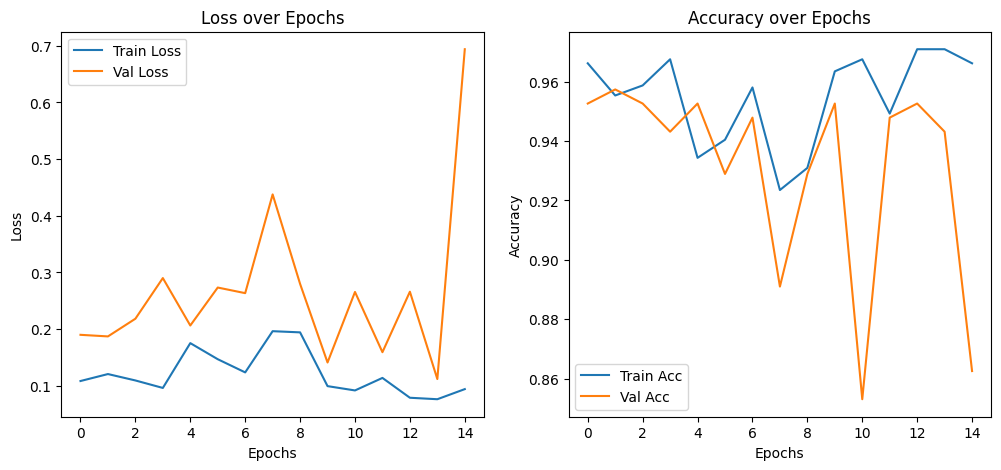


--- Classification Report ---
              precision    recall  f1-score   support

          HC       0.87      0.92      0.90       118
          PD       0.97      0.95      0.96       304

    accuracy                           0.94       422
   macro avg       0.92      0.94      0.93       422
weighted avg       0.94      0.94      0.94       422

Precision: 0.9697
Recall (Sensitivity): 0.9474
F1 Score: 0.9584


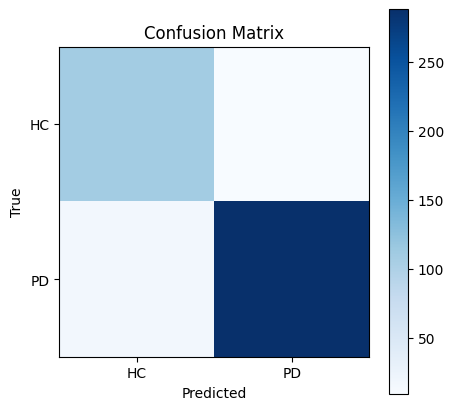

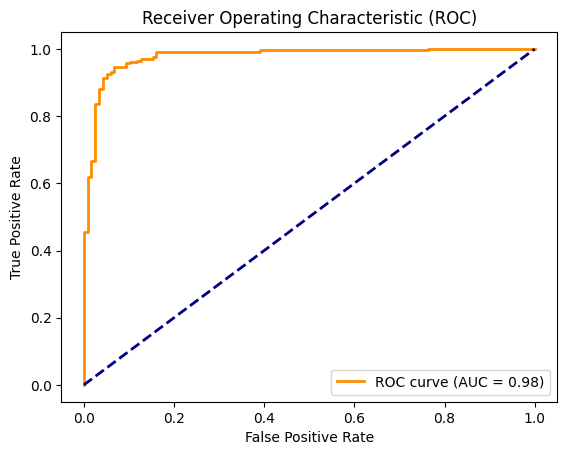


Final Metrics:
Precision: 0.9697
Recall (Sensitivity): 0.9474
F1 Score: 0.9584
Confusion Matrix:
 [[109   9]
 [ 16 288]]


In [10]:
# --- 1) Train the model ---
model, history = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=EPOCHS
)

# --- 2) Plot Accuracy & Loss ---
plot_history(history)

# --- 3) Evaluate on Test Set ---
class_names = ["HC", "PD"]  # <-- replace with your labels
precision, recall, f1, cm = evaluate_model(
    model,
    dataloaders["test"],   # must have dataloaders["test"]
    DEVICE,
    class_names
)

print("\nFinal Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", cm)


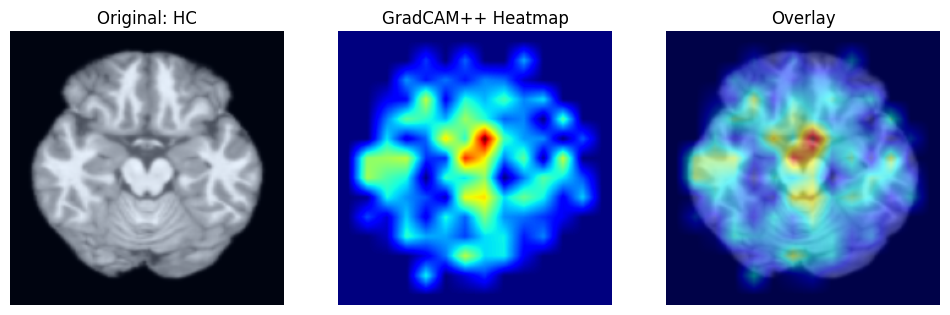

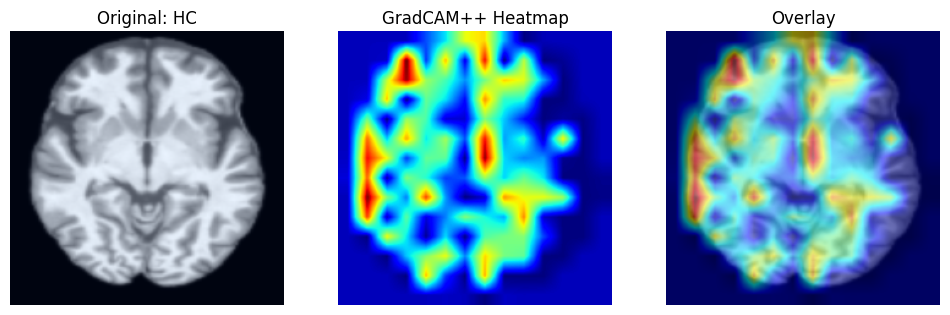

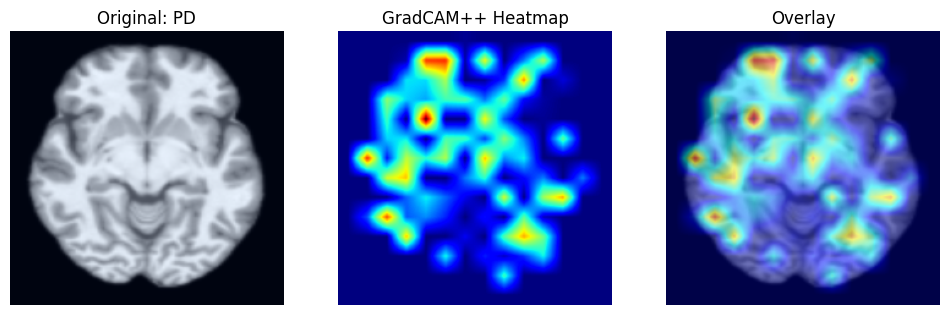

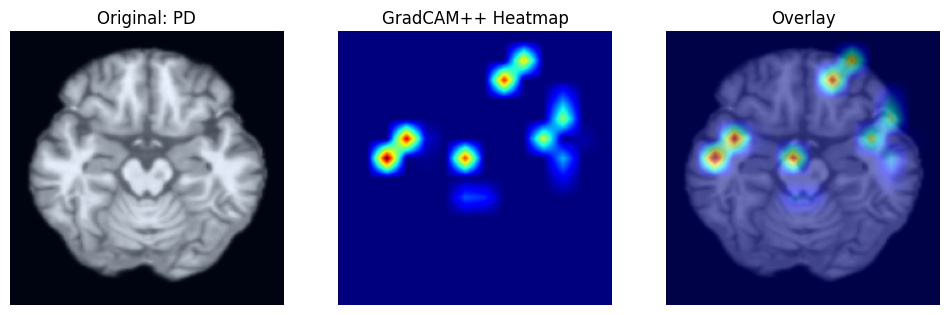

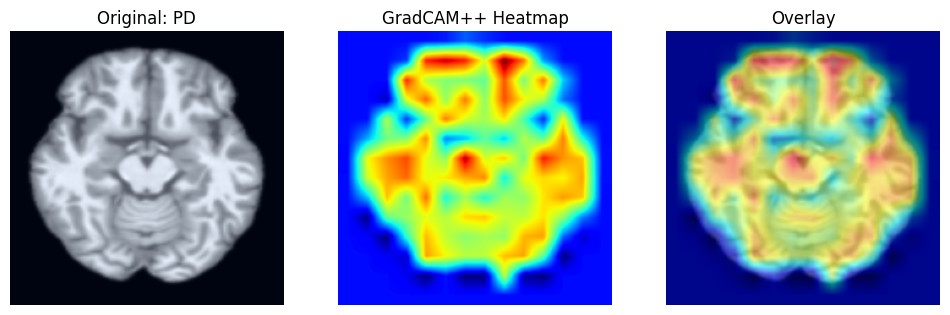

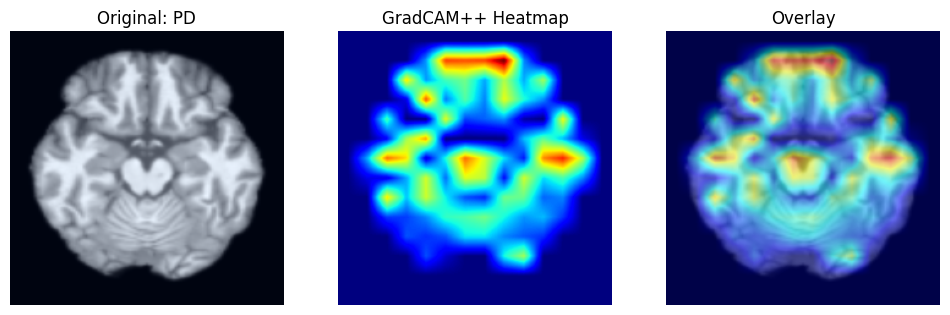

In [19]:
# --- GradCAM++ for ViT (timm) ---
!pip install grad-cam --quiet

import torch
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Pick the correct spatial layer for ViT ---
# ViT patch embedding conv layer gives a proper (B,C,H,W) feature map
target_layers = [model.backbone.patch_embed.proj]

# --- Grad-CAM++ object ---
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# --- Visualization function ---
def visualize_gradcam_pp(model, dataloader, device, class_names, target_layers, num_images=6):
    model.eval()
    images_so_far = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        for i in range(inputs.size(0)):
            input_tensor = inputs[i].unsqueeze(0)  # (1,C,H,W)

            # Convert tensor to numpy image for overlay (original RGB)
            rgb_img = inputs[i].permute(1, 2, 0).detach().cpu().numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # normalize [0,1]

            # --- Run GradCAM++ ---
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]  # (H, W)

            # Overlay CAM on image
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            # --- Plot original, heatmap, overlay ---
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(rgb_img)
            plt.title(f"Original: {class_names[labels[i]]}")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(grayscale_cam, cmap="jet")
            plt.title("GradCAM++ Heatmap")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(visualization)
            plt.title("Overlay")
            plt.axis("off")

            plt.show()

            images_so_far += 1
            if images_so_far >= num_images:
                return

# --- Run on test set ---
visualize_gradcam_pp(
    model,
    dataloaders["test"],
    device=DEVICE,
    class_names=["HC","PD"],
    target_layers=target_layers,
    num_images=6
)


In [32]:
# =============================
# SHAP Visualization for ViT (Modern API)
# =============================
!pip install shap --quiet
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_shap_explainer(model, dataloader, device, class_names, num_images=2, max_evals=500):
    model.eval()

    # Grab a batch
    images, labels = next(iter(dataloader))
    images = images[:num_images].cpu().numpy()  # NCHW -> numpy
    labels = labels[:num_images].cpu().numpy()

    # Convert NCHW -> NHWC for SHAP visualization
    images_vis = images.transpose(0,2,3,1)  # NHWC
    images_vis_uint8 = (np.clip(images_vis, 0, 1) * 255).astype(np.uint8)  # uint8 (for masker)

    # ---------------- Preprocessing for model ----------------
    def preprocess_input(x):
        # NHWC -> NCHW
        x = x.transpose(0,3,1,2)
        # Normalize (ImageNet stats for ViT)
        mean = np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1)
        std = np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1)
        x = (x/255.0 - mean) / std
        return x.astype(np.float32)

    # Model wrapper for SHAP
    def f(x):
        x_tensor = torch.tensor(preprocess_input(x)).to(device)
        with torch.no_grad():
            out = model(x_tensor)
            return torch.nn.functional.softmax(out, dim=1).cpu().numpy()

    # ---------------- SHAP Setup ----------------
    # Masker: inpaint regions when hiding pixels
    masker = shap.maskers.Image("inpaint_telea", images_vis_uint8[0].shape)

    # Explainer with modern API
    explainer = shap.Explainer(f, masker, output_names=class_names)

    # Compute SHAP values
    shap_values = explainer(
        images_vis_uint8,
        max_evals=max_evals,
        batch_size=num_images,
        outputs=shap.Explanation.argsort.flip[:len(class_names)]  # top-k classes
    )

    # ---------------- Visualization ----------------
    shap.image_plot(shap_values)

# Example usage:
# visualize_shap_explainer(model, dataloaders["test"], DEVICE, class_names=["HC","PD"], num_images=4)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [00:58<00:36, 12.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [01:21<00:33, 16.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [01:48<00:20, 20.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [02:15<00:00, 22.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [02:37, 26.24s/it]


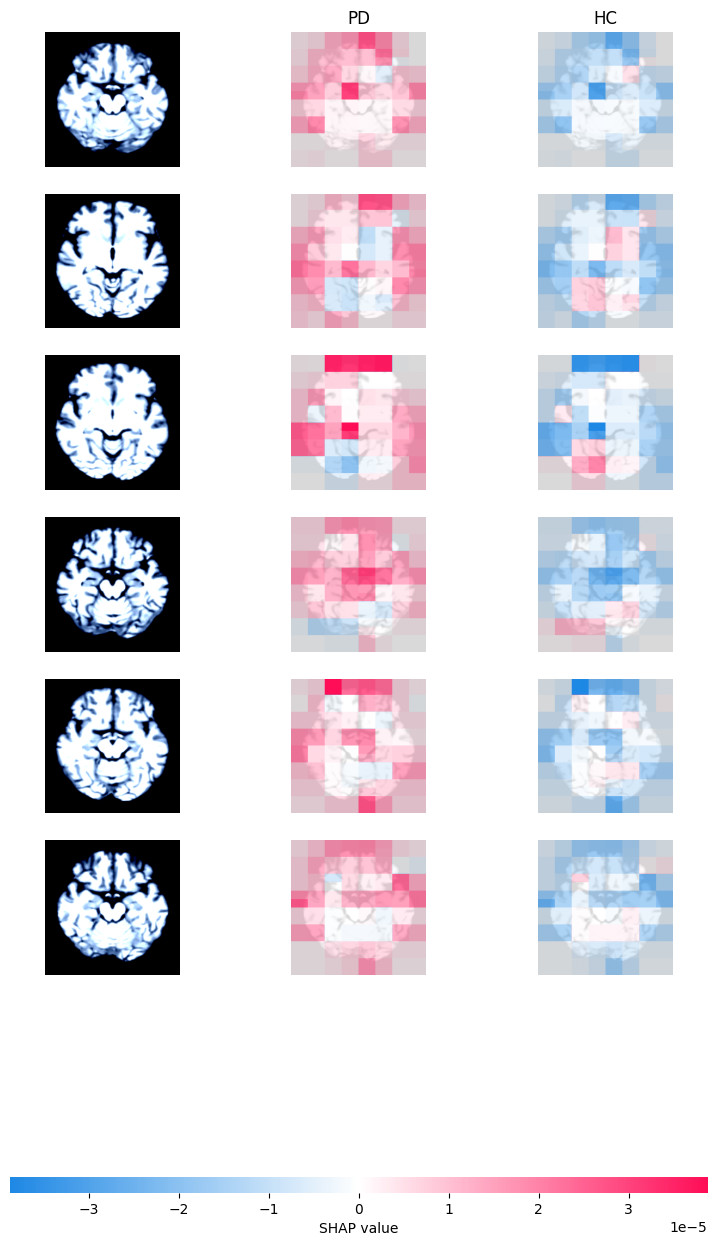

In [33]:
# Run SHAP visualization on test set
visualize_shap_explainer(
    model,
    dataloaders["test"],   # or "val"
    device=DEVICE,
    class_names=["HC","PD"],
    num_images=6
)


In [27]:
#def visualize_shap(images, shap_values, labels, class_names):
    """
#    Show original images + SHAP overlays (positive/negative contributions).
#    """
#    images = images.permute(0,2,3,1).detach().cpu().numpy()  # (B,H,W,C)
#    images = (images - images.min()) / (images.max() - images.min())  # normalize

#    plt.figure(figsize=(12, 8))
#    for i in range(len(images)):
        # --- Original image ---
#        plt.subplot(2, len(images), i+1)
#        plt.imshow(images[i])   # shape (H,W,C), valid for imshow
#        plt.title(f"GT: {class_names[labels[i].item()]}")  # ground truth
#        plt.axis("off")

        # --- SHAP overlay ---
#        plt.subplot(2, len(images), i+1+len(images))
#        shap.image_plot(
#            [shap_values[0][i]],   # pick class-0 SHAP for ith sample
#            images[i:i+1],         # ✅ slice to remove batch dim (shape (H,W,C))
#            show=False
#        )

#    plt.tight_layout()
#    plt.show()
